In [0]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize 
%matplotlib inline

In [0]:
! pip install yfinance

In [0]:
Tech_KR =['005930.KS','000660.KS','035420.KS', '035720.KS' ] #삼성, SK하이닉스, 네이버, 카카오   

def get_price(companies): 
  df=pd.DataFrame()
  for company in companies:
    df[company]=yf.Ticker(company).history(start='2018-04-01', end='2020-03-31')['Close']
  return df

def get_div(companies): 
  df=pd.DataFrame()
  for company in companies:
    df[company]=yf.Ticker(company).history(start='2018-04-01',end='2020-03-31')['Dividends']
  return df  

p_KR=get_price(Tech_KR)
d_KR=get_div(Tech_KR)

p_KR.columns=['SS', 'SKH', 'NVR', 'KKO']
d_KR.columns=['SS', 'SKH', 'NVR', 'KKO']

In [5]:
p_KR.head()

,SS,SKH,NVR,KKO
Date,,,,
2018-04-02,47380.38,79270.88,156585.73,129000.0
2018-04-03,46970.41,79758.41,156585.73,128500.0
2018-04-04,45799.07,78393.34,150402.09,123500.0
2018-04-05,47575.59,80830.95,155388.91,124500.0
2018-04-06,47243.72,78295.84,153593.66,122500.0


# 포트폴리오 도시

In [16]:
# 3000개의 임의의 weights를 생성해서 return, risk를 도시
weights=np.random.rand(len(Tech_KR))
weights=weights/np.sum(weights)
weights

array([0.32743483, 0.12942453, 0.45197552, 0.09116513])

In [20]:
# 임의의 생성된 난수에 대한 Return
r_a= (p_KR.iloc[-1]+d_KR.sum())/p_KR.iloc[0]-1
port_return= np.dot(weights, r_a)
port_return

0.11040686505841522

In [22]:
# 임의의 생성된 난수에 대한 Risk 
covar_KR=(p_KR/p_KR.shift()-1).cov()*252
port_risk= np.dot(weights.T, np.dot(covar_KR, weights))
port_risk

0.0475113446283651

In [0]:
# weights의 조합에 따른 포트폴리오 리턴, 리스크
port_returns=[]
port_risks=[]
for ii in range(3000):
  weights=np.random.rand(len(Tech_KR))
  weights=weights/np.sum(weights)
  r_a= (p_KR.iloc[-1]+d_KR.sum())/p_KR.iloc[0]-1
  port_return= np.dot(weights, r_a)
  covar_KR=(p_KR/p_KR.shift()-1).cov()*252
  port_risk= np.dot(weights.T, np.dot(covar_KR, weights))
  port_returns.append(port_return)
  port_risks.append(port_risk)



In [0]:
port_returns = np.array(port_returns)
port_risks= np.array(port_risks)

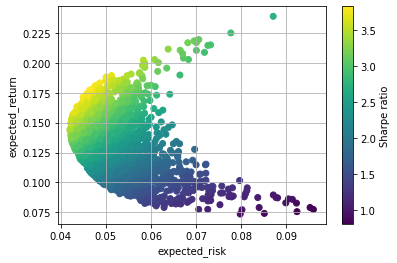

In [30]:
plt.scatter(port_risks, port_returns, c=port_returns/port_risks)
plt.colorbar(label='Sharpe ratio')
plt.xlabel('expected_risk')
plt.ylabel('expected_return')
plt.grid(True)
plt.show()

# 최적화 문제 정의
- 목적함수 : Sharpe ratio(max), Risk (min)
- 선택변수 : weights
- 제약(constraint) : 모든 weights의 합은 1
- 한계(boundary) : 각 weight는 0과 1 사이

# 포트폴리오 최적화 : 세가지 점을 구해봄
- 포트폴리오 리스크 최소
- Sharpe 지수 최대
- 효율적 투자점 : 목표 수익을 달성하기 위한 최소 risk를 가질 수 있는 포트폴리오

In [0]:
minimize(목적함수, w0, constraints=, bounds= )

In [0]:
# 목적함수 정의
# 먼저, weights를 넣으면, return, risk, sharpe raio를 return하는 함수를 정의 => 목적함수 정의 
def get_stats(weights):
  r_a= (p_KR.iloc[-1]+d_KR.sum())/p_KR.iloc[0]-1
  port_return= np.dot(weights, r_a)
  covar_KR=(p_KR/p_KR.shift(1)-1).cov()*252
  port_risk= np.dot(weights.T, np.dot(covar_KR, weights))
  port_sharpe= port_return/ port_risk 
  return [port_return, port_risk, port_sharpe]

def objective_return(weights):
  return -get_stats(weights)[0]

def objective_risk(weights):
  return get_stats(weights)[1]

def objective_sharpe(weights):
  return -get_stats(weights)[2]

In [76]:
get_stats(weights)

[0.1510912435699526, 0.04346470636172771, 3.476182314738794]

In [0]:
# w0 정의 
w0=np.ones(len(Tech_KR))/len(Tech_KR)

In [0]:
# constraints 
constraints={'type':'eq', 'fun': lambda x: np.sum(x)-1 }

In [0]:
# bounds
bound=(0,1)
bounds= tuple(bound for ii in range(len(Tech_KR)))

((0, 1), (0, 1), (0, 1), (0, 1))

In [0]:
# 최적화 1. Risk 최소
opt_risk = minimize(objective_risk, w0, constraints=constraints, bounds=bounds)
# 최적화 2. Sharpe ration 최대
opt_sharpe= minimize(objective_sharpe, w0, constraints=constraints, bounds=bounds )

In [45]:
opt_risk['fun'] # 최적화된 risk
opt_risk['x'] # 그때의 weights (포트폴리오)

array([0.50722008, 0.00642323, 0.23124137, 0.25511533])

In [46]:
-opt_sharpe['fun'] # 최적화된 sharpe ratio
opt_sharpe['x'] # 그때의 weights (포트폴리오)

array([4.48478924e-01, 8.09796927e-16, 9.32472446e-02, 4.58273831e-01])

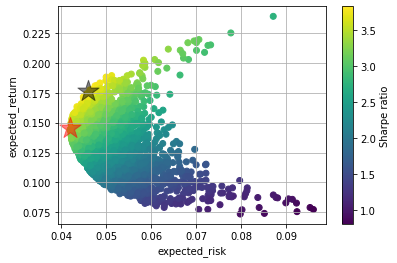

In [51]:
plt.scatter(port_risks, port_returns, c=port_returns/port_risks)
plt.colorbar(label='Sharpe ratio')
pt_opt_sharpe=get_stats(opt_sharpe['x'])
plt.scatter(pt_opt_sharpe[1], pt_opt_sharpe[0], marker='*', s=500, c='black', alpha=0.5)
pt_opt_risk=get_stats(opt_risk['x'])
plt.scatter(pt_opt_risk[1], pt_opt_risk[0], marker='*', s=500, c='red', alpha=0.5)
plt.xlabel('expected_risk')
plt.ylabel('expected_return')
plt.grid(True)
plt.show()

In [0]:
# 효율적 투자점 : 목표 수익을 달성하기 위한 최소 risk를 가질 수 있는 포트폴리오
target_returns= np.linspace(0.14, 0.23, 50)

In [0]:
target_risks=[]
target_port={}
for target_return in target_returns:
  constraints= ({'type':'eq', 'fun': lambda x: np.sum(x)-1 }, 
                {'type':'eq', 'fun': lambda x:get_stats(x)[0]-target_return})
  opt_target=minimize(objective_risk, w0, constraints=constraints, bounds=bounds)
  target_risks.append(opt_target['fun'])
  target_port[target_return]=opt_target['x']

target_risks=np.array(target_risks)

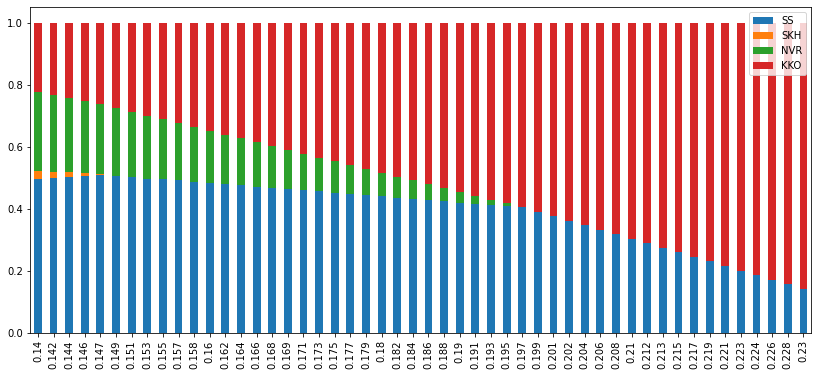

In [103]:
w=pd.DataFrame(target_port.values())
w.columns=['SS', 'SKH', 'NVR', 'KKO']
w.index=target_returns.round(3)
w.plot(figsize=(14,6), kind='bar', stacked=True)

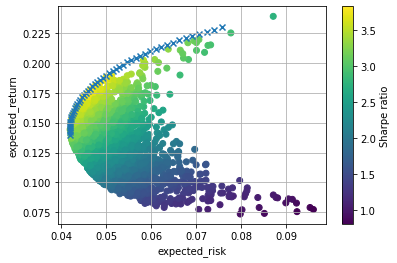

In [109]:
plt.scatter(port_risks, port_returns, c=port_returns/port_risks)
plt.colorbar(label='Sharpe ratio')
plt.scatter(target_risks, target_returns, marker='x')
plt.xlabel('expected_risk')
plt.ylabel('expected_return')
plt.grid(True)
plt.show()